In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay

import xgboost as xgb
import optuna

from imblearn.under_sampling import RandomUnderSampler


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
_FILE_PATH = '../../data/processed/merged_data_2019_2022.csv'
data = pd.read_csv(_FILE_PATH)

In [4]:
X = data.drop(columns=['grav'])
y = data['grav']


In [5]:
_NUMERICAL_TYPES= ['int64', 'float64']
_CATEGORICAL_TYPES= ['object', 'category']
_REPLACE_VALUE_NUM= -1
_REPLACE_VALUE_CAT= "-1"
_REPLACE_NUM_STRATEGY= "mean"
_REPLACE_CAT_STRATEGY= "most_frequent"

# Identifier les colonnes numériques et catégoriques
numerical_columns = X.select_dtypes(include=_NUMERICAL_TYPES).columns.tolist()
categorical_columns = X.select_dtypes(include=_CATEGORICAL_TYPES).columns.tolist()

X[categorical_columns] = X[categorical_columns].astype(str)

# Remplacer les valeurs spécifiques par NaN
X[numerical_columns] = X[numerical_columns].replace(_REPLACE_VALUE_NUM, np.nan)
X[categorical_columns] = X[categorical_columns].replace(_REPLACE_VALUE_CAT, np.nan)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation des colonnes numériques
imputer_num = SimpleImputer(strategy=_REPLACE_NUM_STRATEGY)
X_train[numerical_columns] = imputer_num.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = imputer_num.transform(X_test[numerical_columns])

# Imputation des colonnes catégoriques
imputer_cat = SimpleImputer(strategy=_REPLACE_CAT_STRATEGY)
X_train[categorical_columns] = imputer_cat.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

In [ ]:
_ONEHOT_DROP = "first"

pd.set_option('display.max_columns', None)

# Encodage
scaler_minmax = MinMaxScaler()
X_train[numerical_columns] = scaler_minmax.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler_minmax.transform(X_test[numerical_columns])

scaler_onehot = OneHotEncoder(handle_unknown='ignore', drop=_ONEHOT_DROP)
encoded_train_categorical = scaler_onehot.fit_transform(X_train[categorical_columns]).toarray()
encoded_test_categorical = scaler_onehot.transform(X_test[categorical_columns]).toarray()

# Création de DataFrames avec les colonnes encodées
encoded_train_categorical_df = pd.DataFrame(
    encoded_train_categorical,
    columns=scaler_onehot.get_feature_names_out(categorical_columns),
    index=X_train.index
)

encoded_test_categorical_df = pd.DataFrame(
    encoded_test_categorical,
    columns=scaler_onehot.get_feature_names_out(categorical_columns),
    index=X_test.index
)

X_train = pd.concat([X_train.drop(columns=categorical_columns), encoded_train_categorical_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_columns), encoded_test_categorical_df], axis=1)

In [ ]:
_VARIANCE_TRESHOLD = 0.01

variance_threshold = VarianceThreshold(threshold=_VARIANCE_TRESHOLD)

X_train_filtered = variance_threshold.fit_transform(X_train)
X_test_filtered = variance_threshold.transform(X_test)

# Obtenir les colonnes sélectionnées
selected_columns = X_train.columns[variance_threshold.get_support()]

# Convertir les résultats en DataFrame avec les colonnes sélectionnées
X_train_filtered = pd.DataFrame(X_train_filtered, columns=selected_columns, index=X_train.index)
X_test_filtered = pd.DataFrame(X_test_filtered, columns=selected_columns, index=X_test.index)

# Afficher les résultats pour vérification
removed_columns = X_train.columns[~variance_threshold.get_support()]
print("VarianceTreshold - Colonnes supprimées :", removed_columns.tolist())


VarianceTreshold - Colonnes supprimées : ['nb_v', 'nb_u', 'tpc', 'has_de', 'actp_axe', 'reg_Guadeloupe', 'reg_Guyane', 'reg_Martinique', 'reg_Mayotte', 'reg_Nouvelle-Calédonie', 'reg_Polynésie Française', 'reg_Saint-Barthélemy', 'reg_Saint-Martin', 'reg_Saint-Pierre-et-Miquelon', 'reg_Wallis-et-Futuna']


In [ ]:
# Reequilibrer les classes

# Undersampling

rus = RandomUnderSampler(random_state=42)
X_ru, y_ru = rus.fit_resample(X_train_filtered, y_train)

# verifier
y_ru.value_counts()

grav
0    70953
1    70953
Name: count, dtype: int64

In [9]:
pca = PCA(n_components = 0.9)
pca.fit(X_ru)

PCA(n_components=0.9)

In [11]:
X_train_pca = pca.fit_transform(X_ru)
X_test_pca = pca.transform(X_test_filtered)

In [12]:
def objective(trial):
    params = {
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }
    
    # Validation croisée
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_ru, y_ru):
        X_train, X_val = X_ru.iloc[train_idx], X_ru.iloc[val_idx]
        y_train, y_val = y_ru.iloc[train_idx], y_ru.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))
    
    return np.mean(scores)

# Optimisation avec Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Meilleurs paramètres :", study.best_params)


[I 2025-01-30 15:40:52,344] A new study created in memory with name: no-name-99ca9cdf-f93e-47dc-94c0-4840c4b94676
[I 2025-01-30 15:41:03,888] Trial 0 finished with value: 0.7912914481651169 and parameters: {'learning_rate': 0.2734521344048992, 'max_depth': 10, 'subsample': 0.7577471902016946, 'colsample_bytree': 0.9476549615085266, 'n_estimators': 72}. Best is trial 0 with value: 0.7912914481651169.
[I 2025-01-30 15:41:15,895] Trial 1 finished with value: 0.7948924232607042 and parameters: {'learning_rate': 0.253376211154256, 'max_depth': 8, 'subsample': 0.7944161581048654, 'colsample_bytree': 0.9723136212774637, 'n_estimators': 128}. Best is trial 1 with value: 0.7948924232607042.
[I 2025-01-30 15:41:32,643] Trial 2 finished with value: 0.7976900415166032 and parameters: {'learning_rate': 0.17751984683648603, 'max_depth': 8, 'subsample': 0.9559895608627753, 'colsample_bytree': 0.7148178729171223, 'n_estimators': 234}. Best is trial 2 with value: 0.7976900415166032.
[I 2025-01-30 15:41

Meilleurs paramètres : {'learning_rate': 0.03982988563694302, 'max_depth': 10, 'subsample': 0.926581804508673, 'colsample_bytree': 0.9148549976808182, 'n_estimators': 281}


Fold 1/5
Fold 1 AUC: 0.88
Fold 2/5
Fold 2 AUC: 0.88
Fold 3/5
Fold 3 AUC: 0.89
Fold 4/5
Fold 4 AUC: 0.88
Fold 5/5
Fold 5 AUC: 0.88


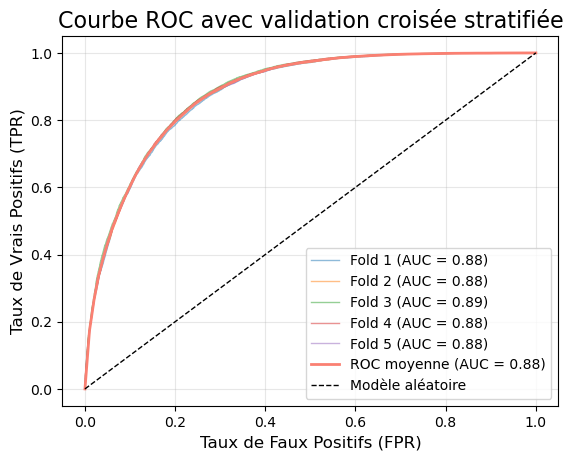

In [14]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

params = study.best_params
params.update({'objective': 'binary:logistic', 'random_state': 42, 'eval_metric': 'logloss'})

accuracy_scores = []
confusion_matrices = []
reports = []
all_fpr = []  # Pour la courbe ROC individuelle
all_tpr = []  # Pour la courbe ROC moyenne

mean_fpr = np.linspace(0, 1, 100)  # Points de référence pour interpoler les courbes ROC

for fold, (train_idx, val_idx) in enumerate(skf.split(X_ru, y_ru)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    X_train, X_val = X_ru.iloc[train_idx], X_ru.iloc[val_idx]
    y_train, y_val = y_ru.iloc[train_idx], y_ru.iloc[val_idx]
    
    train = xgb.DMatrix(data=X_train, label=y_train)
    val = xgb.DMatrix(data=X_val, label=y_val)
    
    eval_set = [(train, 'train'), (val, 'validation')]
    model = xgb.train(params=params, dtrain=train, num_boost_round=300, evals=eval_set, early_stopping_rounds=15, verbose_eval=False)
    
    y_pred = model.predict(val) 
    y_pred_labels = (y_pred >= 0.5).astype(int)
    
    # Calcul des métriques
    accuracy = (y_pred_labels == y_val).mean()
    cm = confusion_matrix(y_val, y_pred_labels)
    report = classification_report(y_val, y_pred_labels, output_dict=True)
    
    accuracy_scores.append(accuracy)
    confusion_matrices.append(cm)
    reports.append(report)
    
    # Courbe Roc
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"Fold {fold + 1} AUC: {roc_auc:.2f}")
    
    all_tpr.append(np.interp(mean_fpr, fpr, tpr))
    all_tpr[-1][0] = 0.0

    # Ajouter les courbes individuelles pour les tracer
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Moyenne des courbes ROC
mean_tpr = np.mean(all_tpr, axis=0)
mean_tpr[-1] = 1.0  # Assurer que le dernier point atteint TPR = 1
mean_auc = auc(mean_fpr, mean_tpr)

# Courbe Roc Moyenne
plt.plot(mean_fpr, mean_tpr, color='salmon', lw=2, label=f"ROC moyenne (AUC = {mean_auc:.2f})")

# Diagonale de base
plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Modèle aléatoire")

plt.title("Courbe ROC avec validation croisée stratifiée", fontsize=16)
plt.xlabel("Taux de Faux Positifs (FPR)", fontsize=12)
plt.ylabel("Taux de Vrais Positifs (TPR)", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()





In [15]:
# Affichage des Accuracy Scores
print("Accuracy Scores par fold :")
for fold, score in enumerate(accuracy_scores, start=1):
    print(f"Fold {fold}: Accuracy = {score:.4f}")
print("\n")

# Affichage des Matrices de Confusion
print("Matrices de Confusion par fold :")
for fold, cm in enumerate(confusion_matrices, start=1):
    print(f"Fold {fold}:\n{cm}\n")
print("\n")

# Affichage des Rapports de Classification
print("Rapport de Classification par fold :")
for fold, report in enumerate(reports, start=1):
    print(f"Fold {fold}:\n")
    print(pd.DataFrame(report).transpose())
    print("\n")

Accuracy Scores par fold :
Fold 1: Accuracy = 0.7987
Fold 2: Accuracy = 0.8022
Fold 3: Accuracy = 0.8039
Fold 4: Accuracy = 0.8038
Fold 5: Accuracy = 0.8012


Matrices de Confusion par fold :
Fold 1:
[[10718  3473]
 [ 2241 11950]]

Fold 2:
[[10771  3420]
 [ 2195 11995]]

Fold 3:
[[10871  3320]
 [ 2245 11945]]

Fold 4:
[[10769  3421]
 [ 2146 12045]]

Fold 5:
[[10719  3471]
 [ 2170 12021]]



Rapport de Classification par fold :
Fold 1:

              precision    recall  f1-score       support
0              0.827070  0.755267  0.789540  14191.000000
1              0.774817  0.842083  0.807051  14191.000000
accuracy       0.798675  0.798675  0.798675      0.798675
macro avg      0.800943  0.798675  0.798295  28382.000000
weighted avg   0.800943  0.798675  0.798295  28382.000000


Fold 2:

              precision    recall  f1-score       support
0              0.830711  0.759002  0.793239  14191.000000
1              0.778138  0.845314  0.810336  14190.000000
accuracy       0.802156  0.

In [17]:
import pandas as pd
import numpy as np

# Affichage des Accuracy Scores avec moyenne
print("Accuracy Scores par fold :")
for fold, score in enumerate(accuracy_scores, start=1):
    print(f"Fold {fold}: Accuracy = {score:.4f}")
print(f"Accuracy moyenne : {np.mean(accuracy_scores):.4f}\n")

# Affichage des Matrices de Confusion avec somme (optionnel)
print("Matrices de Confusion par fold :")
total_cm = np.zeros_like(confusion_matrices[0])  # Initialiser une matrice pour accumuler
for fold, cm in enumerate(confusion_matrices, start=1):
    print(f"Fold {fold}:\n{cm}\n")
    total_cm += cm
print("Matrice de Confusion cumulée sur tous les folds :")
print(total_cm)
print("\n")

# Affichage des Rapports de Classification avec moyennes
print("Rapport de Classification par fold et moyennes globales :")
aggregated_report = {}  # Dictionnaire pour stocker les moyennes
for fold, report in enumerate(reports, start=1):
    print(f"Fold {fold}:\n")
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")
    for metric, values in report.items():
        if isinstance(values, dict):  # Vérifie si la valeur est un dictionnaire
            if metric not in aggregated_report:
                aggregated_report[metric] = {}
            for key, value in values.items():
                if key not in aggregated_report[metric]:
                    aggregated_report[metric][key] = []
                aggregated_report[metric][key].append(value)
        else:
            # Si ce n'est pas un dictionnaire (ex. accuracy), on l'agrège directement
            if metric not in aggregated_report:
                aggregated_report[metric] = []
            aggregated_report[metric].append(values)

# Calculer les moyennes des rapports de classification
average_report = {}
for metric, values in aggregated_report.items():
    if isinstance(values, dict):
        average_report[metric] = {k: np.mean(v) for k, v in values.items()}
    else:
        average_report[metric] = np.mean(values)

print("Rapport de Classification moyen :")
print(pd.DataFrame(average_report).transpose())


Accuracy Scores par fold :
Fold 1: Accuracy = 0.7987
Fold 2: Accuracy = 0.8022
Fold 3: Accuracy = 0.8039
Fold 4: Accuracy = 0.8038
Fold 5: Accuracy = 0.8012
Accuracy moyenne : 0.8020

Matrices de Confusion par fold :
Fold 1:
[[10718  3473]
 [ 2241 11950]]

Fold 2:
[[10771  3420]
 [ 2195 11995]]

Fold 3:
[[10871  3320]
 [ 2245 11945]]

Fold 4:
[[10769  3421]
 [ 2146 12045]]

Fold 5:
[[10719  3471]
 [ 2170 12021]]

Matrice de Confusion cumulée sur tous les folds :
[[53848 17105]
 [10997 59956]]


Rapport de Classification par fold et moyennes globales :
Fold 1:

              precision    recall  f1-score       support
0              0.827070  0.755267  0.789540  14191.000000
1              0.774817  0.842083  0.807051  14191.000000
accuracy       0.798675  0.798675  0.798675      0.798675
macro avg      0.800943  0.798675  0.798295  28382.000000
weighted avg   0.800943  0.798675  0.798295  28382.000000


Fold 2:

              precision    recall  f1-score       support
0              0